## **Pattern Recognition: Pre-Lab 1 - "Voice recognition with Hidden Markov Models and Recurrent Neural Networks"**

---

### **Course Overview**

This project was developed by our team in the **School of Electrical and Computer Engineering (ECE), NTUA (Semester: Autumn 2025-2026).**
- **Course Name:** Pattern Recognition
- **Instructor:** Alexandros Potamianos
- **Submission Deadline:** 29.10.2025

---

### **Team Overview**

Our team consists of the following members:
- **Peppas Michail-Athanasios** | 03121026
- **Augerinos Panagiotis** | 03121023

---

### **Project Scope**

This assignment focuses on the **design and implementation of a small-scale automatic speech recognition (ASR) system** capable of recognizing **isolated English digits (1–9)**, using both **statistical models** and **neural architectures**. The assignment overview can be found here **[Lab 1](https://drive.google.com/file/d/1WAS7SyEMYPBzf5EKtD6IoojYjlJxFg_y/view?usp=sharing)**.

The key objectives are:

* **a. Audio Feature Extraction and Analysis**  
  - Load and analyze speech recordings using `librosa`.  
  - Compute and visualize **Mel-Frequency Cepstral Coefficients (MFCCs)**, **deltas**, and **delta-deltas**.  
  - Compare **MFCCs** and **Mel Filterbank Spectral Coefficients (MFSCs)** and interpret their differences.  

* **b. Feature Visualization and Dimensionality Reduction**  
  - Plot histograms and scatter plots of extracted features.  
  - Apply **Principal Component Analysis (PCA)** for 2D and 3D visualization and evaluate variance preservation.

* **c. Classification of Spoken Digits**  
  - Construct fixed-length feature vectors (mean and standard deviation per coefficient).  
  - Train and evaluate multiple classifiers (e.g., **Bayesian**, **Naive Bayes**, **SVM**, **k-NN**, **Decision Tree**).  
  - Perform data normalization and report classification accuracies.

* **d. Temporal Modeling with Sequential Architectures**  
  - Explore **Hidden Markov Models (HMMs)** using `pomegranate`.  
  - Implement and train a **Recurrent Neural Network (RNN)** — optionally with **LSTM** or **GRU** cells — in `PyTorch` to predict time-series patterns.

* **e. Comparative Evaluation and Discussion**  
  - Analyze results qualitatively and quantitatively across different approaches.  
  - Discuss feature significance, model performance, and generalization across speakers.

---

### **Mounting Google Drive**

Before any processing can take place, it is necessary to **mount Google Drive** to access the dataset and supporting files.  
This operation links the Google Drive storage to the **Colab environment**, making files accessible under the path `/content/drive/MyDrive/`.

**Purpose:**  
- Allow direct reading of files (e.g., `pr_lab2_data/digits`) stored in Google Drive.  
- Simplify file handling and path definitions for subsequent steps in the notebook.  

After successful authorization, all project data will be available for loading and analysis.


In [2]:
# ==============================================================
# Mount Google Drive
# ==============================================================
# This step connects Google Drive to the Colab environment
# and allows access to datasets stored within it.

from google.colab import drive

# Mount the drive at /content/drive
drive.mount('/content/drive')

# Define the dataset path for easy reuse later
import os

# The path containing the data
drive_base = '/content/drive/MyDrive/'
dataset_path = os.path.join(drive_base, 'NTUA-Pattern_Recognition/Lab1/pr_lab2_data')

print(f"Drive mounted successfully. Dataset located at:\n{dataset_path}")


Mounted at /content/drive
Drive mounted successfully. Dataset located at:
/content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data


### **Step 1 — Praat Analysis (Manual, Included in Report)**

This step is conducted **outside the Colab notebook**, using the **Praat** software.  
It involves visually inspecting and acoustically analyzing two recordings:

- `onetwothree1.wav` (male speaker)  
- `onetwothree8.wav` (female speaker)

**Tasks performed in Praat:**
- Display and compare waveforms and spectrograms.
- Measure the **average pitch** and **first three formants (F1–F3)** for vowels *a*, *u*, *i*.
- Discuss differences between male and female speakers (pitch range, formant spacing).

These measurements, observations, and screenshots are **included in the written report** (not executed in this notebook) as required by the assignment.


### **Step 2 — Isolated-Digit Loader**

#### **Goal**
Discover and load **isolated English digit** recordings (1–9) from `digits/`, convert audio to **mono 16 kHz**, and return exactly **three lists** for the next steps.

---

#### **Public API (used in the code cell)**
- **`parse_digits_wavs_labels_speakers(dataset_root, subdir="digits", target_sr=16000, recursive=True)`**
  - Recursively finds `.wav` files under `<dataset_root>/<subdir>/` and **keeps only names of the following format**:  
    `"<digitword><speaker>.wav"` (e.g., `eight8.wav`).
  - Maps the word to a numeric label **1–9** and uses the numeric suffix as **speaker ID**.
  - Loads each file with `librosa.load(..., sr=16000, mono=True)` to ensure **uniform sampling**.
  - Processes files in **sorted order** for reproducibility.
  - **Returns (in this order):**  
    1) `wavs`: list of `np.ndarray` waveforms  
    2) `y_num`: list of integer labels (1–9)  
    3) `speakers`: list of speaker IDs (strings)

---

#### **Sanity prints**
- A one-line summary: number of parsed files and the sampling rate (16 kHz).
- Counts of returned lists (they must be equal).
- A few `(label, speaker)` pairs and example waveform lengths (in samples).



In [24]:
# ==============================================================
# Step 2 — Data Parsing (Loading the Speech Corpus)
# ==============================================================

import os
import re
from glob import glob
from typing import List, Tuple, Dict, Optional

import numpy as np
import librosa

# Map digit words → numeric labels for Scheme A ("eight8.wav", etc.)
_WORD_TO_NUM: Dict[str, int] = {
    "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
    "six": 6, "seven": 7, "eight": 8, "nine": 9
}

# File name pattern for Scheme A: "<digitword><speaker>.wav"
_SCHEME_A_RE = re.compile(
    r"^(one|two|three|four|five|six|seven|eight|nine)(\d+)\.wav$",
    re.IGNORECASE
)

def parse_digits_wavs_labels_speakers(
    dataset_root: str,
    subdir: str = "digits",
    target_sr: int = 16000,
    recursive: bool = True
) -> Tuple[List[np.ndarray], List[int], List[str]]:
    """
    Load isolated-digit recordings using Scheme A only and return EXACTLY three lists:
      wavs      : List[np.ndarray]  (mono waveforms, resampled to target_sr)
      y_num     : List[int]         (numeric labels 1..9)
      speakers  : List[str]         (speaker IDs as strings)
    """
    search_path = os.path.join(dataset_root, subdir)
    if not os.path.isdir(search_path):
        raise FileNotFoundError(f"Directory not found: {search_path}")

    pattern = "**/*.wav" if recursive else "*.wav"
    files = glob(os.path.join(search_path, pattern), recursive=recursive)
    files.sort()

    wavs: List[np.ndarray] = []
    y_num: List[int] = []
    speakers: List[str] = []

    for f in files:
        fname = os.path.basename(f)
        m: Optional[re.Match] = _SCHEME_A_RE.match(fname)
        if m is None:
            # Ignore anything not matching Scheme A (no Scheme B / no phrase files here)
            continue

        digit_word = m.group(1).lower()
        spk_id     = m.group(2)       # speaker digits after the word
        label      = _WORD_TO_NUM[digit_word]

        # Load mono waveform at the assignment SR (16 kHz)
        wav, _ = librosa.load(f, sr=target_sr, mono=True)
        wavs.append(wav.astype(np.float32))
        y_num.append(int(label))
        speakers.append(str(spk_id))

    print(f"Parsed {len(wavs)} isolated-digit files at {target_sr} Hz "
          f"from: {os.path.join(dataset_root, subdir)}")
    return wavs, y_num, speakers


# --- Example invocation (uses dataset_path defined in the Drive-mount cell) ---
dataset_root = dataset_path
wavs, y_num, speakers = parse_digits_wavs_labels_speakers(dataset_root)
Fs = 16000  # keep SR available for later steps

# Quick sanity printout
print(f"Returned lists: wavs={len(wavs)}, labels={len(y_num)}, speakers={len(speakers)}")
print(f"First 5 (label, speaker): {list(zip(y_num, speakers))[:5]}")
print(f"Example waveform lengths (samples): {[len(w) for w in wavs[:3]]}")



Parsed 133 isolated-digit files at 16000 Hz from: /content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data/digits
Returned lists: wavs=133, labels=133, speakers=133
First 5 (label, speaker): [(8, '1'), (8, '10'), (8, '11'), (8, '12'), (8, '13')]
Example waveform lengths (samples): [11891, 8821, 10485]


### **Step 3 — MFCC, Δ, and ΔΔ Feature Extraction**

#### **Goal**
For each utterance, compute **13 MFCCs** with a **25 ms** analysis window and **10 ms** hop; then compute **Δ** and **ΔΔ** (first and second temporal derivatives). Concatenate per frame to obtain **39-dimensional** features.

---

#### **Functions (What Each Does)**
- **`extract_mfcc_and_deltas(wavs, sr, ...)`**  
  Computes per-frame MFCCs and their temporal derivatives (Δ, ΔΔ), then stacks them to form a 39-D feature sequence per utterance. Returns four aligned lists:
  - `mfcc_seqs` — MFCCs `(T, 13)`  
  - `delta_seqs` — Δ features `(T, 13)`  
  - `delta2_seqs` — ΔΔ features `(T, 13)`  
  - `feats39_seqs` — stacked features `(T, 39)`

- **Example invocation block**  
  Calls the function using the parsed waveforms `wavs` and sampling rate `Fs` (from Step 2), then prints a short summary (number of utterances and example shapes) to verify dimensions.

---

#### **Key Parameters (Summary)**
| **Parameter** | **Type / Default** | **Role** | **Practical Impact** |
|---|---|---|---|
| `wavs` | `List[np.ndarray]` | Waveforms to process. | One feature sequence per utterance. |
| `sr` | `int` (expected **16000**) | Sampling rate (Hz). | Drives ms→samples conversion and time/freq scales. |
| `n_mfcc` | `int = 13` | Number of MFCCs. | Standard for speech; aligns with lab spec. |
| `win_ms` | `int = 25` | Window length (ms). | We **fix the actual analysis window** to 25 ms via `win_length`. |
| `hop_ms` | `int = 10` | Frame step (ms). | Temporal stride; controls number of frames (**T**). |
| `n_mels` | `int = 26` | Mel filterbank channels. | Common baseline front-end for ASR. |
| `center` | `bool = True` | Center frames (with padding). | Matches common librosa defaults. |
| `n_fft` *(derived)* | next power of two ≥ `win_ms·sr/1000` | FFT size. | Speeds STFT while keeping `win_length=25 ms`. |
| `win_length` *(derived)* | `round(win_ms·sr/1000)` | **Actual window size** used by STFT. | Ensures the window is **exactly 25 ms** (lab requirement). |
| `hop_length` *(derived)* | `round(hop_ms·sr/1000)` | Step in samples. | Implements the **10 ms** hop exactly. |

*Defaults (`n_mfcc=13`, `win_ms=25`, `hop_ms=10`, `n_mels=26`) follow the assignment.  
**Important:** We explicitly set `win_length = 25 ms` so the analysis window remains 25 ms even if `n_fft` is a larger power of two.*

---

#### **Output Interpretation**

- `MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512, win_length=400.`  
  Confirms lab spec: **13 MFCCs**; **25 ms** window (`win_length=400 @ 16 kHz`); **10 ms** hop (`hop_length=160`); **26** mel filters; FFT uses a power-of-two (e.g., 512) for speed.

- `Utterances processed: 133`  
  All recordings were processed (e.g., **133** total).

- `Example shapes (first utterance): {'mfcc': (T, 13), 'delta': (T, 13), 'delta2': (T, 13), 'stacked_39': (T, 39)}`  
  Per frame we have **13 MFCCs + 13 Δ + 13 ΔΔ = 39** features; time dimension is **T**.

- **Why 39 features?**  
  13 static MFCCs (spectral envelope) + 13 Δ (velocity) + 13 ΔΔ (acceleration) capture spectral shape and short-term dynamics — the standard ASR baseline.



In [25]:
# ==============================================================
# Step 3 — MFCC, Δ, and ΔΔ Feature Extraction
# --------------------------------------------------------------
# Extracts per-frame speech features:
#   • 13 MFCCs (librosa includes C0 by default)
#   • Δ (first temporal derivatives) and ΔΔ (second temporal derivatives)
# Uses EXACTLY: 25 ms analysis window and 10 ms hop at 16 kHz.
# Concatenates [MFCC | Δ | ΔΔ] → 39-dim features per frame.
# Returns aligned lists of MFCC, Δ, ΔΔ, and stacked (39-D) feature sequences.
# ==============================================================

from typing import List, Tuple
import numpy as np
import librosa

def extract_mfcc_and_deltas(
    wavs: List[np.ndarray],
    sr: int,
    n_mfcc: int = 13,
    win_ms: int = 25,
    hop_ms: int = 10,
    n_mels: int = 26,
    center: bool = True
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Compute MFCCs, Δ (deltas), and ΔΔ (delta-deltas) per utterance and stack them to 39-dim.
    Returns four aligned lists: mfcc, delta, delta2, stacked (T, 3*n_mfcc).

    Implementation notes:
      • We set 'win_length' explicitly to match EXACT 25 ms windows at the given 'sr'.
      • We keep 'n_fft' as a power of two for FFT efficiency, but DO NOT let it change the window duration.
      • librosa.feature.delta expects shape (features, frames), hence the transpose before/after.
    """
    # ---- Frame configuration (in samples) ----
    win_length = int(round((win_ms / 1000.0) * sr))   # 25 ms → 400 at 16 kHz
    hop_length = int(round((hop_ms / 1000.0) * sr))   # 10 ms → 160 at 16 kHz

    # Use a power-of-two FFT size for speed, but preserve exact window duration via 'win_length'.
    n_fft = 1 << (win_length - 1).bit_length()        # e.g., next pow2 ≥ 400 → 512

    mfcc_seqs: List[np.ndarray] = []
    delta_seqs: List[np.ndarray] = []
    delta2_seqs: List[np.ndarray] = []
    feats39_seqs: List[np.ndarray] = []

    for wav in wavs:
        # ---- MFCCs ----
        # librosa returns (n_mfcc, T); we transpose to (T, n_mfcc) so time is the first axis.
        mfcc = librosa.feature.mfcc(
            y=wav,
            sr=sr,
            n_mfcc=n_mfcc,
            n_mels=n_mels,
            n_fft=n_fft,
            win_length=win_length,   # keep the analysis window EXACTLY 25 ms
            hop_length=hop_length,   # keep hop EXACTLY 10 ms
            center=center
        ).T  # (T, n_mfcc)

        # ---- Δ and ΔΔ along time ----
        # librosa.feature.delta expects (features, frames), so transpose to (n_mfcc, T), then back.
        d1 = librosa.feature.delta(mfcc.T, order=1).T   # (T, n_mfcc)
        d2 = librosa.feature.delta(mfcc.T, order=2).T   # (T, n_mfcc)

        # ---- Stack per frame: (T, 13) | (T, 13) | (T, 13) → (T, 39) ----
        f39 = np.hstack([mfcc, d1, d2]).astype(np.float32)

        # Cast to float32 for compactness & consistency
        mfcc_seqs.append(mfcc.astype(np.float32))
        delta_seqs.append(d1.astype(np.float32))
        delta2_seqs.append(d2.astype(np.float32))
        feats39_seqs.append(f39)

    # ---- Log configuration and a simple consistency check ----
    print(
        f"MFCCs/deltas extracted: n_mfcc={n_mfcc}, window={win_ms} ms, hop={hop_ms} ms, "
        f"n_mels={n_mels}, n_fft={n_fft}, win_length={win_length}."
    )
    # Sanity assertion on the first utterance shape
    if feats39_seqs:
        assert feats39_seqs[0].shape[1] == 3 * n_mfcc, "Stacked feature dimension must be 3*n_mfcc."

    return mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs


# ---- Example invocation using parsed waveforms and sampling rate from Step 2 ----
mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

# ---- Sanity output ----
num_utts = len(mfcc_seqs)
first_shapes = {
    "mfcc": None if num_utts == 0 else mfcc_seqs[0].shape,
    "delta": None if num_utts == 0 else delta_seqs[0].shape,
    "delta2": None if num_utts == 0 else delta2_seqs[0].shape,
    "stacked_39": None if num_utts == 0 else feats39_seqs[0].shape,
}
print(f"Utterances processed: {num_utts}")
print(f"Example shapes (first utterance): {first_shapes}")


MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512, win_length=400.
Utterances processed: 133
Example shapes (first utterance): {'mfcc': (75, 13), 'delta': (75, 13), 'delta2': (75, 13), 'stacked_39': (75, 39)}


### **Step 4 — MFCC Histograms and MFSC vs MFCC Correlation Analysis**

####**Goal**  
(A) Test how well low-order MFCCs separate digits **n1=6** and **n2=3** using **MFCC₁** and **MFCC₂** histograms.  
(B) Compare feature correlation **before** DCT (MFSC = log-mel energies) and **after** DCT (MFCC) using **two utterances per digit from different speakers**. All features use **25 ms** window and **10 ms** hop at **16 kHz** (exact `win_length`/`hop_length`), with `n_fft` set to the next power-of-two for FFT efficiency.

---

#### **What each function does**

- **`collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, target_digit, coeff_idx)`**  
  Concatenates a **single MFCC coefficient** (e.g., index 0 → MFCC₁, index 1 → MFCC₂) **across all frames and utterances** of `target_digit`.  
  Output: `np.ndarray` of shape `(total_frames_for_digit,)` used to plot per-digit histograms.

- **`choose_k_per_digit(y_num, speakers, digit, k=2)`**  
  Selects up to **k utterance indices** for a given `digit` ensuring **distinct speakers** (greedy; falls back if not enough speakers).  
  Output: list of indices used in the correlation analysis.

- **`compute_mfsc_sequence(wav, sr, n_mels=13, win_ms=25, hop_ms=10, center=True)`**  
  Computes **MFSCs** = **log-mel energies** (pre-DCT) with **exact window/hop**; returns a matrix **(T, 13)** where `T` is the number of frames.

- **`corr_matrix(features_TxD)`**  
  Returns the **D×D Pearson correlation matrix** across feature dimensions for an input matrix **(T, D)**. If `T < 2`, returns `NaN`s.

- **`plot_corr_grid(indices, title_prefix, compute_feats_fn)`**  
  For each utterance index in `indices`, computes features via `compute_feats_fn(idx)`, builds a **correlation matrix**, and plots them in a single row with a **shared colorbar**.

> **Inputs required from previous steps:**  
> `wavs` (audio), `Fs=16000`, `mfcc_seqs` (from Step 3), and the metadata lists `y_num`, `speakers`.

---

#### **A. MFCC₁ and MFCC₂ Histograms (all frames, digits 6 vs 3)**

| **Statistic** | **digit 6** | **digit 3** | **Interpretation** |
|---|---:|---:|---|
| **MFCC₁** (C0/energy-tilt) | mean = **−252.82**, std = **63.04** | mean = **−255.22**, std = **60.99** | Very close → weak separability. |
| **MFCC₂** | mean = **42.21**, std = **23.06** | mean = **59.14**, std = **19.61** | Clear mean shift → better separation. |
| **Frame count** | **1167** | **1149** | Comparable sizes; balanced evidence. |

**Observations.**  
MFCC₁ overlaps heavily (mostly energy/tilt); MFCC₂ is shifted upward for digit 3, offering **useful discriminability**.

---

#### **B. MFSC vs MFCC Correlation (two utterances per digit, different speakers)**

- **MFSC (13-D log-mel energies):** strong **off-diagonal** correlations (adjacent mel bands co-vary) → **redundant** spectral representation.  
- **MFCC (13-D, post-DCT):** correlation matrices are **near-diagonal** with reduced off-diagonal mass → **decorrelated** features.

**Takeaway.**  
The DCT in MFCCs **reduces inter-feature correlation** relative to MFSCs. This favors models that assume independent (or simply-correlated) features (e.g., Gaussian/Naive Bayes) and generally yields a more compact, informative representation.

---

#### **Summary**

- **MFCC₂** adds clear class information for **6 vs 3**; **MFCC₁** alone is weak.
- **MFSCs** exhibit strong internal correlation; **MFCCs** are more decorrelated thanks to the DCT.


Histogram summary (mean, std, count):
digit 6 — MFCC1      | mean=-252.8179 std=63.0411 count=1167
digit 6 — MFCC2      | mean=42.2128 std=23.0640 count=1167
digit 3 — MFCC1      | mean=-255.2218 std=60.9909 count=1149
digit 3 — MFCC2      | mean=59.1361 std=19.6144 count=1149


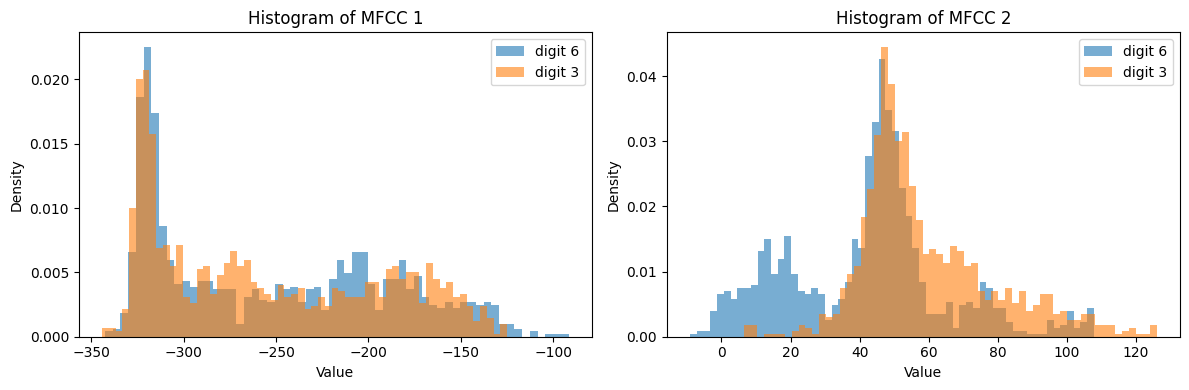


Correlation analysis indices for n1=6: [89, 90] (speakers: ['1', '10'])
Correlation analysis indices for n2=3: [103, 104] (speakers: ['1', '10'])


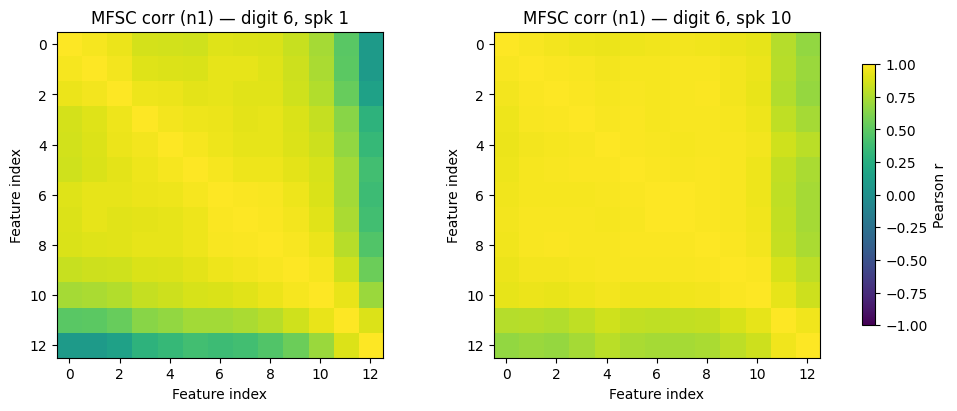

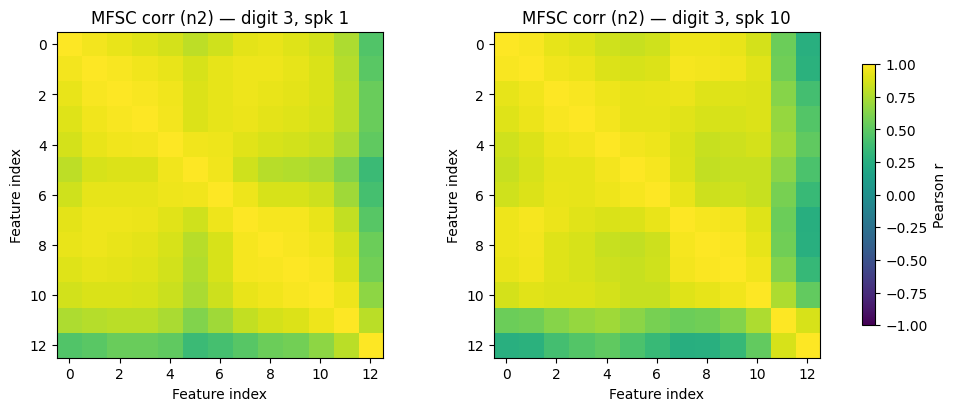

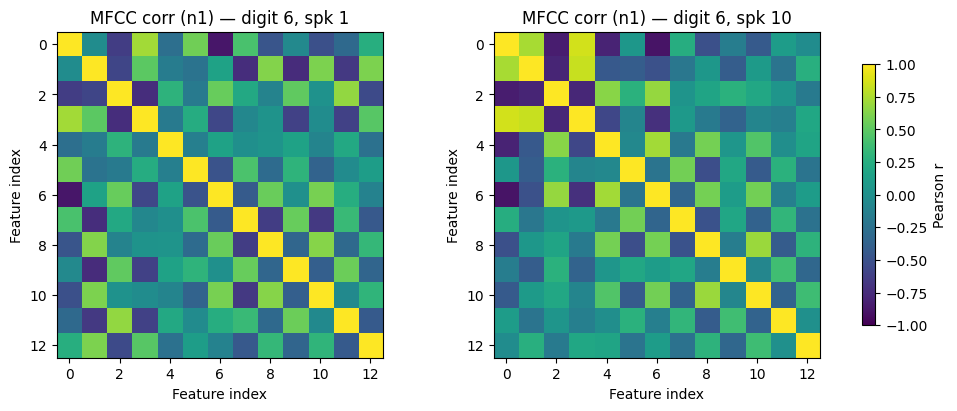

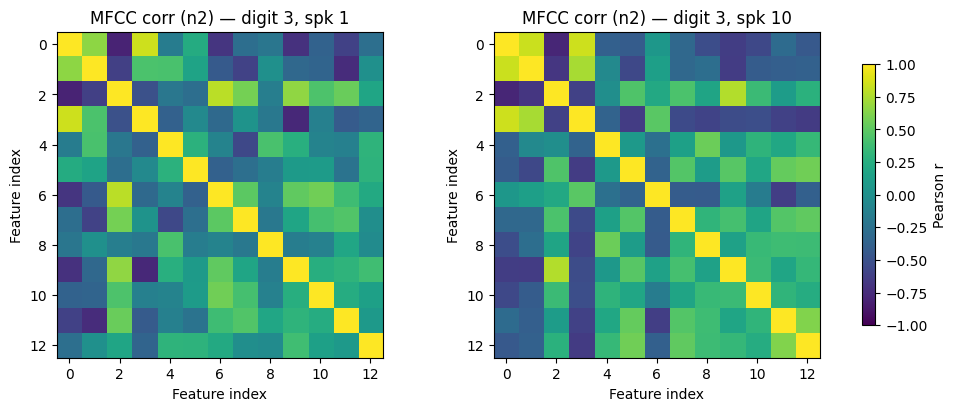

In [6]:
# ==============================================================
# Step 4 — MFCC histograms (n1=6, n2=3) and MFSC vs MFCC correlation
#            using TWO utterances per digit from DIFFERENT speakers
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import librosa
from typing import List, Tuple

# ---------------- Configuration (from student IDs) ----------------
n1, n2 = 6, 3  # digits chosen from the two student IDs (03121026, 03121023)

# ---------------- Utilities ----------------

def collect_mfcc_coeffs_for_digit(mfcc_seqs: List[np.ndarray],
                                  y_num: List[int],
                                  target_digit: int,
                                  coeff_idx: int) -> np.ndarray:
    """
    Gather one MFCC coefficient across all frames from all utterances of a target digit.
    Returns a 1-D array of values (concatenation across utterances and frames).
    """
    vals = [seq[:, coeff_idx] for seq, y in zip(mfcc_seqs, y_num) if int(y) == int(target_digit)]
    return np.concatenate(vals, axis=0) if vals else np.array([])

def choose_k_per_digit(y_num: List[int], speakers: List[str], digit: int, k: int = 2) -> List[int]:
    """
    Choose up to k utterance indices for the given digit from DISTINCT speakers.
    Falls back gracefully if less diversity is available.
    """
    seen = set()
    idxs = []
    for i, y in enumerate(y_num):
        if int(y) == int(digit):
            spk = speakers[i]
            if spk not in seen:
                idxs.append(i)
                seen.add(spk)
            if len(idxs) == k:
                break
    return idxs

def compute_mfsc_sequence(wav: np.ndarray,
                          sr: int,
                          n_mels: int = 13,
                          win_ms: int = 25,
                          hop_ms: int = 10,
                          center: bool = True) -> np.ndarray:
    """
    Compute MFSCs (Mel Filterbank Spectral Coefficients = log-mel energies, pre-DCT)
    with EXACT 25 ms window and 10 ms hop. Returns (T, n_mels).
    """
    win_length = int(round((win_ms / 1000.0) * sr))    # 25 ms → 400 @ 16 kHz
    hop_length = int(round((hop_ms / 1000.0) * sr))    # 10 ms → 160 @ 16 kHz
    n_fft = 1 << (win_length - 1).bit_length()         # pow2 ≥ 400 → 512

    S = librosa.feature.melspectrogram(
        y=wav, sr=sr,
        n_mels=n_mels,
        n_fft=n_fft, win_length=win_length, hop_length=hop_length,
        center=center, power=2.0
    )  # (n_mels, T)
    logS = np.log(S + 1e-10)
    return logS.T  # (T, n_mels)

def corr_matrix(features_TxD: np.ndarray) -> np.ndarray:
    """
    Compute D×D Pearson correlation across feature dims for a (T, D) matrix.
    If T < 2, returns NaNs.
    """
    if features_TxD.ndim != 2 or features_TxD.shape[0] < 2:
        D = features_TxD.shape[1] if features_TxD.ndim == 2 else 0
        return np.full((D, D), np.nan, dtype=float)
    return np.corrcoef(features_TxD, rowvar=False)

# ---------------- 4A. Histograms for MFCC1 and MFCC2 (n1 vs n2 over ALL utterances) ----------------

# Ensure MFCCs exist (from Step 3). If not, compute minimal MFCCs directly and
# keep EXACT 25/10 ms windowing to match the lab spec.
if 'mfcc_seqs' not in globals():
    win_length = int(round(0.025 * Fs))
    hop_length = int(round(0.010 * Fs))
    n_fft = 1 << (win_length - 1).bit_length()
    mfcc_seqs = [
        librosa.feature.mfcc(
            y=w, sr=Fs, n_mfcc=13,
            n_fft=n_fft, win_length=win_length, hop_length=hop_length
        ).T
        for w in wavs
    ]

mfcc1_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=0)  # MFCC_1
mfcc2_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=1)  # MFCC_2
mfcc1_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=0)
mfcc2_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=1)

# Print quick numeric summaries (helps the discussion in the markdown)
def summarize(name: str, arr: np.ndarray):
    return (name, float(np.mean(arr)), float(np.std(arr)), int(arr.size)) if arr.size else (name, np.nan, np.nan, 0)

summary_stats = [
    summarize(f"digit {n1} — MFCC1", mfcc1_n1),
    summarize(f"digit {n1} — MFCC2", mfcc2_n1),
    summarize(f"digit {n2} — MFCC1", mfcc1_n2),
    summarize(f"digit {n2} — MFCC2", mfcc2_n2),
]
print("Histogram summary (mean, std, count):")
for name, m, s, c in summary_stats:
    print(f"{name:20s} | mean={m:.4f} std={s:.4f} count={c}")

# Plot histograms (overlaid, per coefficient)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(mfcc1_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[0].hist(mfcc1_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[0].set_title("Histogram of MFCC 1")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Density")
axs[0].legend()

axs[1].hist(mfcc2_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[1].hist(mfcc2_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[1].set_title("Histogram of MFCC 2")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Density")
axs[1].legend()
plt.tight_layout()
plt.show()

# ---------------- 4B. MFSC vs MFCC correlation (TWO utterances per digit) ----------------

# Pick two utterances per digit with DISTINCT speakers (fallback as needed)
idxs_n1 = choose_k_per_digit(y_num, speakers, digit=n1, k=2)
idxs_n2 = choose_k_per_digit(y_num, speakers, digit=n2, k=2)

print() # empty line
print(f"Correlation analysis indices for n1={n1}: {idxs_n1} (speakers: {[speakers[i] for i in idxs_n1]})")
print(f"Correlation analysis indices for n2={n2}: {idxs_n2} (speakers: {[speakers[i] for i in idxs_n2]})")

# Compute correlation matrices for MFSC and MFCC for each selected utterance
def plot_corr_grid(indices: List[int], title_prefix: str, compute_feats_fn):
    """
    Plot a horizontal grid of correlation matrices (one per utterance index).
    """
    if not indices:
        print(f"Warning: no indices for {title_prefix}.")
        return
    cols = len(indices)
    fig, axs = plt.subplots(1, cols, figsize=(5 * cols, 4), constrained_layout=True)
    if cols == 1:
        axs = [axs]
    last_im = None
    for j, idx in enumerate(indices):
        feats_TxD = compute_feats_fn(idx)   # (T, D)
        C = corr_matrix(feats_TxD)
        last_im = axs[j].imshow(C, vmin=-1, vmax=1, aspect='equal')
        axs[j].set_title(f"{title_prefix} — digit {y_num[idx]}, spk {speakers[idx]}")
        axs[j].set_xlabel("Feature index")
        axs[j].set_ylabel("Feature index")
    fig.colorbar(last_im, ax=axs, shrink=0.8, label="Pearson r")
    plt.show()

# MFSC correlation (13-D, exact 25/10 ms)
plot_corr_grid(
    idxs_n1, "MFSC corr (n1)", lambda idx: compute_mfsc_sequence(wavs[idx], Fs, n_mels=13, win_ms=25, hop_ms=10)
)
plot_corr_grid(
    idxs_n2, "MFSC corr (n2)", lambda idx: compute_mfsc_sequence(wavs[idx], Fs, n_mels=13, win_ms=25, hop_ms=10)
)

# MFCC correlation (13-D) for the SAME utterances (to visualize DCT decorrelation)
plot_corr_grid(
    idxs_n1, "MFCC corr (n1)", lambda idx: mfcc_seqs[idx]
)
plot_corr_grid(
    idxs_n2, "MFCC corr (n2)", lambda idx: mfcc_seqs[idx]
)


### **Step 5 — Utterance-Level Aggregation and 2D Scatter**

#### **Goal**
Convert each utterance’s frame-level features into a **fixed-length vector** and visualize low-dimensional separability.  
For every utterance, we take the 39-D sequence from Step 3 (**13 MFCC + 13 Δ + 13 ΔΔ**) and compute **mean** and **standard deviation** over time → a **78-D** vector `[μ(39) | σ(39)]`.

---

#### **What the code does**
- Builds `X_stats ∈ ℝ^{N×78}` with labels `y ∈ {1,…,9}` by concatenating per-feature **means** and **stds** across frames.  
- Plots **dimension 0** vs **dimension 1**, i.e., **μ(MFCC₁)** vs **μ(MFCC₂)** (time means of the first two cepstral coefficients).  
  - Recall: MFCC₁ (C0) is largely energy/tilt-related; MFCC₂ reflects coarse spectral slope / formant spacing.

---

#### **How to read the figure**
- **X-axis:** μ(MFCC₁). This tends to vary with global energy/tilt → **weak class separation**.  
- **Y-axis:** μ(MFCC₂). Captures broad spectral shape → typically **more discriminative** than MFCC₁.  
- **Markers/legend:** Each digit (1–9) uses a distinct marker; cluster positions show where that digit’s utterances tend to lie.

---

#### **Observed results (from our plot)**
- **Overall overlap** is substantial using only μ(MFCC₁) and μ(MFCC₂) — expected for such a compact summary.  
- **μ(MFCC₂) separates better**: higher values are frequent for digits like **1** and **7**, whereas **6** often occupies lower μ(MFCC₂).  
- **Speaker/utterance variability** produces visible intra-class spread (both axes), consistent with multi-speaker data.  
- Net: this 2D view provides some intuition (especially from μ(MFCC₂)) but is **not linearly separable** across all digits.

---

#### **Answering the assignment’s intent**
- We produced the required **utterance-level vectors** (mean+std over the 39-D frames → 78-D) and visualized the **first two dimensions** (μ(MFCC₁), μ(MFCC₂)).  
- The figure demonstrates that **MFCC₂** carries **more discriminative information** than **MFCC₁**, while **two statistics alone are insufficient** for clean class separation.  
- This motivates the next steps (PCA to 2D/3D and downstream classifiers) to capture **richer structure** than what the two means alone can provide.


Utterances: 133, Feature dimension: 78 (expected 78)


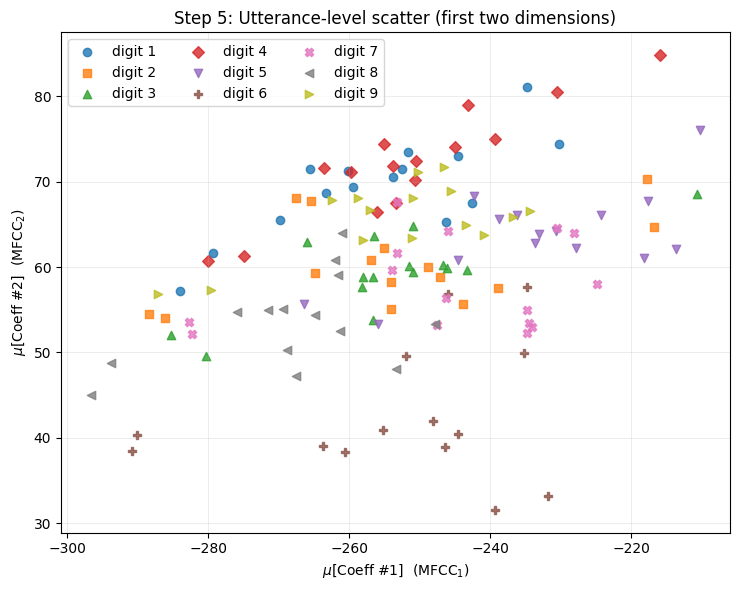

In [7]:
# ==============================================================
# Step 5 — Utterance-level feature vectors (mean & std) and 2D scatter
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

# Ensure frame-level 39-D features exist (from Step 3); otherwise compute them.
if 'feats39_seqs' not in globals():
    mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

def aggregate_mean_std(seqs: List[np.ndarray]) -> np.ndarray:
    """
    Convert a list of frame sequences (T_i x D) to utterance-level vectors.
    For each utterance, compute mean and std over time for each of the D features,
    then concatenate [mean(0..D-1), std(0..D-1)] → (2D,).
    """
    X = []
    for F in seqs:                       # F: (T, D)
        mu = F.mean(axis=0)              # (D,)
        sd = F.std(axis=0, ddof=0)       # (D,)
        X.append(np.hstack([mu, sd]))    # (2D,)
    return np.asarray(X)                  # (N, 2D)

# Build utterance-level dataset: X has 78 dims when D=39
X_stats = aggregate_mean_std(feats39_seqs)   # shape: (N, 78)
y_labels = np.asarray(y_num)                 # integer digit labels 1..9
speakers_arr = np.asarray(speakers)

assert X_stats.shape[0] == y_labels.shape[0], "Mismatch: features and labels must have same N."
print(f"Utterances: {X_stats.shape[0]}, Feature dimension: {X_stats.shape[1]} (expected 78)")

# Scatter of the first two dimensions:
# With stacking order [MFCC(13) | Δ(13) | ΔΔ(13)], dims 0 and 1 correspond to MFCC1_mean and MFCC2_mean.
dims = (0, 1)

digits_unique = sorted(np.unique(y_labels).astype(int))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '<', '>']  # 9 distinct markers for digits 1..9
plt.figure(figsize=(7.5, 6))
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    plt.scatter(
        X_stats[sel, dims[0]],
        X_stats[sel, dims[1]],
        label=f"digit {d}",
        alpha=0.8,
        marker=markers[i % len(markers)],
        s=36
    )

plt.xlabel(r"$\mu$[Coeff #1]  (MFCC$_1$)")
plt.ylabel(r"$\mu$[Coeff #2]  (MFCC$_2$)")
plt.title("Step 5: Utterance-level scatter (first two dimensions)")
plt.legend(ncol=3, frameon=True)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()


### **Step 6 — PCA Dimensionality Reduction (2D & 3D)**

#### **Goal**
Apply **PCA** to the utterance-level features to obtain **2D** and **3D** visualizations and report the **explained variance** captured by the principal components, as requested in the PDF.

---

#### **Pipeline (what this cell does)**
- **Input:** `X_stats ∈ ℝ^{N×78}` (per-utterance `[μ(39) | σ(39)]` from Step 5) with digit labels `y`.
- **Standardize:** `StandardScaler` (zero mean, unit variance per feature).
- **PCA:** Fit `PCA(n_components=3)` on standardized data → project to **(PC1, PC2)** and **(PC1, PC2, PC3)**.
- **Plots:** 2D and 3D scatters colored/labeled by digit.
- **Report:** Print the **explained variance ratio (EVR)** per component and the **cumulative** EVR for 2D and 3D.

---

#### **What is EVR (Explained Variance Ratio)?**  
For PCA eigenvalues $\{\lambda_k\}$ of the (standardized) data covariance, the EVR of component $k$ is
$
\mathrm{EVR}_k \;=\; \frac{\lambda_k}{\sum_j \lambda_j}.
$
It is the **fraction of total variance** captured by principal component $k$. Across **all** components, EVRs sum to 1 (100%).

---

#### **What is cumulative EVR?**  
For the first $m$ components,
$
\mathrm{CumulativeEVR}(m) \;=\; \sum_{k=1}^{m} \mathrm{EVR}_k,
$
i.e., the **total fraction of variance preserved** by keeping the top $m$ PCs. It’s used to judge how many PCs are needed to retain a desired amount of information.

---

#### **Our run — explained variance**
- EVR per component: **PC1 = 12.54%**, **PC2 = 7.51%**, **PC3 = 6.33%**  
- **Cumulative (2D): 20.06%** | **Cumulative (3D): 26.39%**

#### **How to read the figures.**
- PCA axes are **unsupervised** directions of **maximal variance** in the standardized 78-D space.  
- Clear, tight clusters → stronger class structure; heavy overlap → limited separability by a linear unsupervised projection.

---

#### **Observations (from our plots)**
- **2D (PC1–PC2):** modest grouping tendencies but **substantial overlap** among digits.  
- **3D (PC1–PC3):** small improvement, yet **classes still overlap** notably.  
- Interpretation: **variance is spread across many dimensions**; the top 2–3 PCs capture only ~20–26% and do **not** align perfectly with digit boundaries (expected for unsupervised PCA).

#### **Notes for the report**
- We applied PCA to **2D and 3D**, reported **EVR** and **cumulative EVR**, and discussed that low-dimensional PCA views provide **limited separability**.  
- For **classification** (Step 7), we will use the **full 78-D features** (with train-only scaling), or consider **supervised** projections (e.g., LDA) if dimensionality reduction is desired.


Explained variance ratio per component (PC1..PC3): [0.12543578 0.07514068 0.06332982]
Cumulative (2D): 0.2006
Cumulative (3D): 0.2639


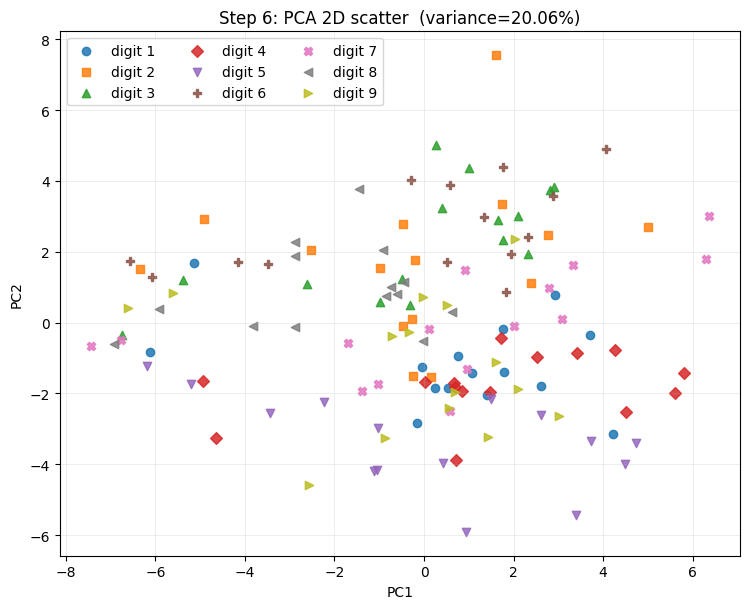

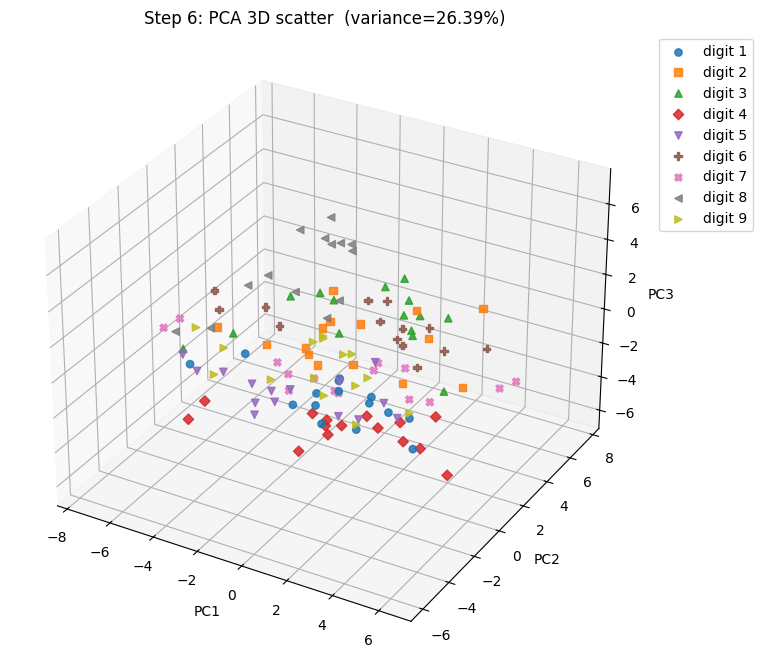

In [8]:
# ==============================================================
# Step 6 — PCA dimensionality reduction (2D & 3D) and scatter plots
# (polished: deterministic PCA solver, extra safety checks)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---- Ensure utterance-level 78-D vectors exist (from Step 5); otherwise build them. ----
if 'X_stats' not in globals():
    if 'feats39_seqs' not in globals():
        # Build 39-D frame features if missing (uses Step-3 function)
        mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

    def aggregate_mean_std(seqs):
        """Aggregate each (T, 39) sequence to a (78,) vector = [means(39) | stds(39)]."""
        X = []
        for F in seqs:                   # F: (T, 39)
            mu = F.mean(axis=0)          # (39,)
            sd = F.std(axis=0, ddof=0)   # (39,)
            X.append(np.hstack([mu, sd]))# (78,)
        return np.asarray(X)             # (N, 78)

    X_stats = aggregate_mean_std(feats39_seqs)   # (N, 78)
    y_labels = np.asarray(y_num)                 # (N,)
    speakers_arr = np.asarray(speakers)

# Basic safety: shape should be (N, 78).
assert X_stats.ndim == 2 and X_stats.shape[1] == 78, "Expected (N, 78) utterance-level features."

# ------------------------------------------------------------------
# Standardize features before PCA (zero mean / unit variance per dim)
# NOTE: For visualization/exploration Step 6, fitting on ALL data is fine.
#       If PCA becomes part of a classification pipeline, fit on TRAIN only.
# ------------------------------------------------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X_stats)

# ------------------------------------------------------------------
# PCA fit (3 comps). Use a deterministic solver; 'full' is exact SVD.
# ------------------------------------------------------------------
pca = PCA(n_components=3, svd_solver="full")  # random_state not used by 'full'
X_pca_3d = pca.fit_transform(X_std)           # (N, 3)
X_pca_2d = X_pca_3d[:, :2]                    # (N, 2)

# Report explained variance
evr = pca.explained_variance_ratio_           # (3,)
print("Explained variance ratio per component (PC1..PC3):", evr)
print(f"Cumulative (2D): {evr[:2].sum():.4f}")
print(f"Cumulative (3D): {evr[:3].sum():.4f}")

# ------------------------------------------------------------------
# 2D scatter (PC1 vs PC2)
# ------------------------------------------------------------------
digits_unique = sorted(np.unique(y_labels).astype(int))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '<', '>']  # 9 markers
plt.figure(figsize=(7.6, 6.2))
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    plt.scatter(
        X_pca_2d[sel, 0], X_pca_2d[sel, 1],
        marker=markers[i % len(markers)],
        s=36, alpha=0.85, label=f"digit {d}"
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Step 6: PCA 2D scatter  (variance={evr[:2].sum():.2%})")
plt.legend(ncol=3, frameon=True)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()

print()  # empty line

# ------------------------------------------------------------------
# 3D scatter (PC1, PC2, PC3)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(8.2, 6.6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    ax.scatter(
        X_pca_3d[sel, 0], X_pca_3d[sel, 1], X_pca_3d[sel, 2],
        marker=markers[i % len(markers)], s=28, alpha=0.85, label=f"digit {d}"
    )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"Step 6: PCA 3D scatter  (variance={evr[:3].sum():.2%})")
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.show()


### **Step 7 (main) — Baseline classifiers, metrics, and error analysis**

**What this cell does**
- **Split & normalize:** Stratified **70/30** train/test split; **StandardScaler** fitted on **train** only and applied to **test**.
- **Train six baselines:**  
  1) **Bayesian (full-cov)** with ridge-regularized class covariances  
  2) **Gaussian Naive Bayes** (diagonal Σ)  
  3) **SVM (RBF)**  
  4) **k-NN (k=5)**  
  5) **Logistic Regression** (multinomial)  
  6) **Decision Tree** (uses raw features; trees don’t need scaling)
- **Report:** Accuracy table + bar chart.
- **Error analysis:** **Confusion matrix + classification report** for the **best** and **worst** models.

---

#### **Metric definitions**
Let TP, FP, FN be per-class counts; “support” is the number of **true** test samples of that class.

- **Accuracy:** $\frac{\text{# correct predictions}}{\text{# all samples}}$.
- **Precision (per class):** $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}$ — when the model predicts this class, how often it is correct.
- **Recall (per class):** $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$ — of the true items of this class, how many the model found.
- **F1 (per class):** harmonic mean of precision and recall, $\frac{2PR}{P+R}$.
- **Support:** number of test instances for that class.
- **Macro avg:** unweighted mean over classes.
- **Weighted avg:** mean over classes **weighted by support**.

---

#### **Test accuracies (78-D utterance features)**
- **Bayesian (full-cov): 0.825**  ← best  
- **SVM (RBF): 0.800**  
- **Logistic Regression: 0.750**  
- **GaussianNB: 0.575**  
- **k-NN (k=5): 0.525**  
- **Decision Tree: 0.275**  ← worst

**Interpretation (why this ordering makes sense):**
- Full-cov Bayes benefits from modeling **feature correlations** (our 78-D vectors are correlated), with ridge regularization stabilizing Σ estimates.  
- SVM and Logistic are strong linear/nonlinear baselines after scaling.  
- GaussianNB assumes independence → lower accuracy here.  
- k-NN is sensitive to scale and local density in small-N regimes.  
- The un-tuned Decision Tree **overfits** and generalizes poorly on this small dataset.

---

#### **Best model — Bayesian (full-cov) @ 0.825**
Key per-class results (precision / recall from the report):
- Perfect classes: **4, 6, 8** (precision=recall=1.00); note the **small supports** (4–5 each).
- **Digit 1:** precision **1.00**, recall **0.40** → very **conservative** predictions for “1”: few false positives, **many misses** (true 1’s labeled as other digits).
- **Digit 7:** precision **0.625**, recall **1.00** → finds all 7’s but **over-predicts** 7 (false positives).
- Others (2, 3, 5, 9): decent F1 (0.67–1.00) with small supports.

**Confusion matrix (visual read):** mostly diagonal; errors concentrate in **digit 1** (missed) and **digit 7** (extra hits). This matches the precision/recall trade-offs above.

---

#### **Worst model — Decision Tree @ 0.275**
- Many classes show **near-zero** precision/recall (e.g., 1, 2, 5, 9).  
- Slightly better on **4** and **6** (F1 ≈ 0.67), but overall **heavy off-diagonal** mass in the confusion matrix.
- Likely causes: **high variance** with limited training data per class, lack of pruning/tuning, and no shared structure learning across classes.



Step 7 — Test accuracies (baseline 78-D features):
Model                      Accuracy
------------------------  ---------
Bayesian (full-cov)          0.8250
SVM (RBF)                    0.8000
Logistic Regression          0.7500
Naive Bayes (GaussianNB)     0.5750
k-NN (k=5)                   0.5250
Decision Tree                0.2750



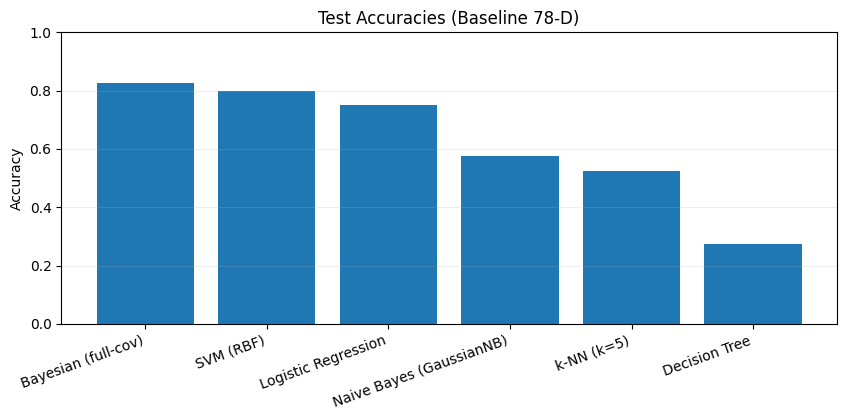

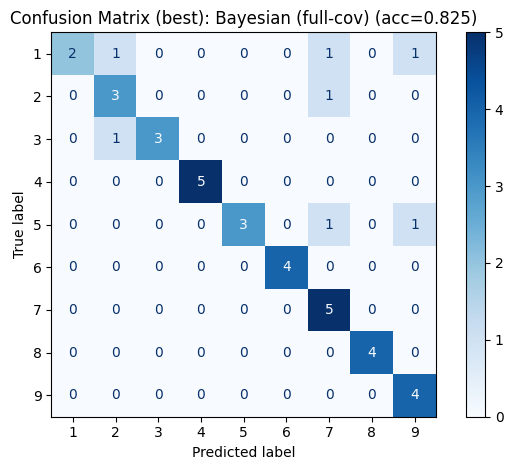


Classification report for best model: Bayesian (full-cov)

              precision    recall  f1-score   support

           1      1.000     0.400     0.571         5
           2      0.600     0.750     0.667         4
           3      1.000     0.750     0.857         4
           4      1.000     1.000     1.000         5
           5      1.000     0.600     0.750         5
           6      1.000     1.000     1.000         4
           7      0.625     1.000     0.769         5
           8      1.000     1.000     1.000         4
           9      0.667     1.000     0.800         4

    accuracy                          0.825        40
   macro avg      0.877     0.833     0.824        40
weighted avg      0.880     0.825     0.819        40



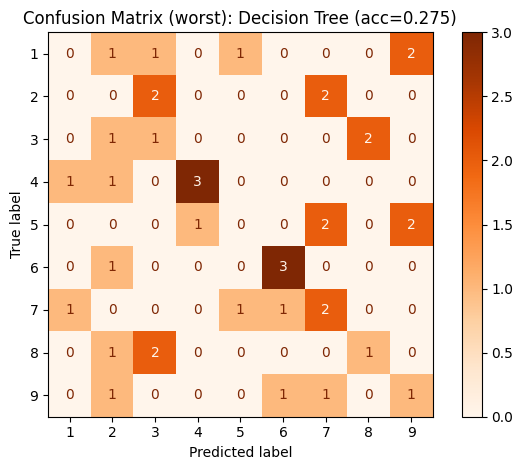



Classification report for worst model: Decision Tree

              precision    recall  f1-score   support

           1      0.000     0.000     0.000         5
           2      0.000     0.000     0.000         4
           3      0.167     0.250     0.200         4
           4      0.750     0.600     0.667         5
           5      0.000     0.000     0.000         5
           6      0.600     0.750     0.667         4
           7      0.286     0.400     0.333         5
           8      0.333     0.250     0.286         4
           9      0.200     0.250     0.222         4

    accuracy                          0.275        40
   macro avg      0.260     0.278     0.264        40
weighted avg      0.259     0.275     0.262        40



In [17]:
# ==============================================================
# Step 7 (main) — Train/Test split, normalization, and classifiers
#   - Custom Gaussian Bayes (full covariance; regularized)
#   - Gaussian Naive Bayes
#   - SVM (RBF)
#   - k-NN
#   - Logistic Regression
#   - Decision Tree
#   + Summary table, accuracy bar chart
#   + Confusion matrices and classification reports for BEST and WORST models
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------
# Ensure utterance-level features exist (N x 78) and labels (N,)
# If needed, derive them from Step 3 outputs (feats39_seqs)
# ---------------------------------------------------------
if 'X_stats' not in globals():
    if 'feats39_seqs' not in globals():
        # Build 39-D frame features if missing (uses Step-3 function and exact 25/10 ms)
        mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

    def aggregate_mean_std(seqs):
        """
        Aggregate each frame sequence (T, 39) to a (78,) vector:
          [ means(39) | stds(39) ] across time.
        """
        X = []
        for F in seqs:                     # F: (T, 39)
            mu = F.mean(axis=0)            # (39,)
            sd = F.std(axis=0, ddof=0)     # (39,)
            X.append(np.hstack([mu, sd]))  # (78,)
        return np.asarray(X)               # (N, 78)

    X_stats = aggregate_mean_std(feats39_seqs)  # (N, 78)
    y_labels = np.asarray(y_num)                # (N,)
    speakers_arr = np.asarray(speakers)

# ---------------------------------------------------------
# Custom Gaussian Bayes (full class covariance; ridge-regularized)
# ---------------------------------------------------------
@dataclass
class FullCovGaussianBayes:
    reg: float = 1e-3  # ridge regularization for covariance matrices

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit a class-conditional Gaussian model with a full covariance per class.
        A small 'reg' * I is added to each covariance for numerical stability.
        """
        self.classes_ = np.unique(y)
        D = X.shape[1]
        self.priors_: Dict[int, float] = {}
        self.means_: Dict[int, np.ndarray] = {}
        self.cov_inv_: Dict[int, np.ndarray] = {}
        self.logdet_: Dict[int, float] = {}

        for c in self.classes_:
            Xc = X[y == c]
            self.priors_[int(c)] = Xc.shape[0] / X.shape[0]
            mu = Xc.mean(axis=0)
            # Full covariance with ridge (ensures positive-definiteness)
            Sigma = np.cov(Xc, rowvar=False) + self.reg * np.eye(D)
            self.means_[int(c)] = mu

            # Robust inverse + log-determinant handling
            sign, logdet = np.linalg.slogdet(Sigma)
            if sign <= 0:
                # Fallback to pseudo-inverse and eigenvalue-based logdet if needed
                Sigma_inv = np.linalg.pinv(Sigma)
                logdet = np.log(np.clip(np.linalg.eigvalsh(Sigma), 1e-12, None)).sum()
            else:
                Sigma_inv = np.linalg.inv(Sigma)

            self.cov_inv_[int(c)] = Sigma_inv
            self.logdet_[int(c)] = float(logdet)

        self._const_ = -0.5 * D * np.log(2.0 * np.pi)
        return self

    def _logpdf(self, x: np.ndarray, c: int) -> float:
        """
        Log-pdf of a Gaussian N(mu_c, Sigma_c) up to an additive constant;
        uses precomputed inverse and log-determinant.
        """
        mu = self.means_[c]
        Si = self.cov_inv_[c]
        diff = x - mu
        quad = diff @ Si @ diff  # quadratic form
        return self._const_ - 0.5 * (self.logdet_[c] + quad)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class with maximum posterior (log prior + log-likelihood).
        """
        preds = []
        for x in X:
            scores = [np.log(self.priors_[int(c)]) + self._logpdf(x, int(c)) for c in self.classes_]
            preds.append(self.classes_[int(np.argmax(scores))])
        return np.asarray(preds)

# ---------------------------------------------------------
# Split (70/30 stratified), scale (fit on train, apply to both)
# ---------------------------------------------------------
X = X_stats
y = y_labels

indices = np.arange(len(y))
idx_train, idx_test = train_test_split(
    indices, test_size=0.30, stratify=y, random_state=0  # reproducible, stratified
)

X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

# Keep raw copies for models that don't need scaling (e.g., Decision Tree)
X_train_raw, X_test_raw = X_train.copy(), X_test.copy()

# Standardize for models that benefit from scaling
scaler_main = StandardScaler()
X_train_std = scaler_main.fit_transform(X_train)
X_test_std  = scaler_main.transform(X_test)

# ---------------------------------------------------------
# Train/evaluate models
# ---------------------------------------------------------
results_main: Dict[str, float] = {}
models_fitted: Dict[str, object] = {}

# 1) Bayesian classifier (full-cov Gaussian)
bayes = FullCovGaussianBayes(reg=1e-2).fit(X_train_std, y_train)
acc = accuracy_score(y_test, bayes.predict(X_test_std))
results_main["Bayesian (full-cov)"] = acc
models_fitted["Bayesian (full-cov)"] = bayes

# 2) Naive Bayes (diagonal covariance assumption)
gnb = GaussianNB().fit(X_train_std, y_train)
acc = accuracy_score(y_test, gnb.predict(X_test_std))
results_main["Naive Bayes (GaussianNB)"] = acc
models_fitted["Naive Bayes (GaussianNB)"] = gnb

# 3) SVM with RBF kernel
svm = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=0).fit(X_train_std, y_train)
acc = accuracy_score(y_test, svm.predict(X_test_std))
results_main["SVM (RBF)"] = acc
models_fitted["SVM (RBF)"] = svm

# 4) k-NN
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_std, y_train)
acc = accuracy_score(y_test, knn.predict(X_test_std))
results_main["k-NN (k=5)"] = acc
models_fitted["k-NN (k=5)"] = knn

# 5) Logistic Regression (multinomial by default)
lr = LogisticRegression(max_iter=2000, random_state=0).fit(X_train_std, y_train)
acc = accuracy_score(y_test, lr.predict(X_test_std))
results_main["Logistic Regression"] = acc
models_fitted["Logistic Regression"] = lr

# 6) Decision Tree (uses raw features; scaling not needed)
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_raw, y_train)
acc = accuracy_score(y_test, dt.predict(X_test_raw))
results_main["Decision Tree"] = acc
models_fitted["Decision Tree"] = dt

# ---------------------------------------------------------
# Formatted summary table (aligned) + accuracy bar chart
# ---------------------------------------------------------
print("Step 7 — Test accuracies (baseline 78-D features):")
rows = sorted(results_main.items(), key=lambda kv: -kv[1])  # sort by accuracy desc
name_w = max(len(name) for name, _ in rows)
print(f"{'Model':<{name_w}}  {'Accuracy':>9}")
print(f"{'-'*name_w}  {'-'*9}")
for name, acc in rows:
    print(f"{name:<{name_w}}  {acc:>9.4f}")

print() # Blank line

plt.figure(figsize=(8.6, 4.3))
model_names = [n for n, _ in rows]
accs = [a for _, a in rows]
plt.bar(range(len(model_names)), accs)
plt.xticks(range(len(model_names)), model_names, rotation=20, ha='right')
plt.ylabel("Accuracy")
plt.title("Test Accuracies (Baseline 78-D)")
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # Blank line between plots

# ---------------------------------------------------------
# Confusion matrix + classification report for the BEST model
# ---------------------------------------------------------
best_name, best_acc = rows[0]                 # top accuracy
best_model = models_fitted[best_name]
# Use standardized features for all except Decision Tree
Xbest_test = X_test_std if best_name != "Decision Tree" else X_test_raw

y_pred_best = best_model.predict(Xbest_test)

labels_sorted = sorted(np.unique(y_test))
cm_best = confusion_matrix(y_test, y_pred_best, labels=labels_sorted)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=labels_sorted)
disp_best.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (best): {best_name} (acc={best_acc:.3f})")
plt.tight_layout()
plt.show()

# Classification report (BEST)
print(f"\nClassification report for best model: {best_name}\n")
print(classification_report(y_test, y_pred_best, digits=3))

# ---------------------------------------------------------
# Confusion matrix + classification report for the WORST model
# ---------------------------------------------------------
worst_name, worst_acc = rows[-1]              # lowest accuracy
worst_model = models_fitted[worst_name]
# Use standardized features for all except Decision Tree
Xworst_test = X_test_std if worst_name != "Decision Tree" else X_test_raw

y_pred_worst = worst_model.predict(Xworst_test)

cm_worst = confusion_matrix(y_test, y_pred_worst, labels=labels_sorted)
disp_worst = ConfusionMatrixDisplay(confusion_matrix=cm_worst, display_labels=labels_sorted)
disp_worst.plot(cmap="Oranges", values_format="d")
plt.title(f"Confusion Matrix (worst): {worst_name} (acc={worst_acc:.3f})")
plt.tight_layout()
plt.show()

print() # Blank line between plots

# Classification report (WORST)
print(f"\nClassification report for worst model: {worst_name}\n")
print(classification_report(y_test, y_pred_worst, digits=3))

# ---------------------------------------------------------
# Expose artifacts for potential reuse in the bonus step
# ---------------------------------------------------------
step7_results_main = results_main
step7_idx_train = idx_train
step7_idx_test = idx_test
step7_random_state = 0


### **Step 7 (Bonus) — Augmenting with Extra Acoustic Descriptors (90-D) and Comparison**

**What the code adds.**  
For each waveform we compute frame-level **extra descriptors**, then aggregate **mean** and **std** per utterance and concatenate with the 78-D baseline → **90-D** vectors:
- **Zero-Crossing Rate (ZCR):** sign-change rate (voicing/noisiness cue).  
- **Spectral Centroid:** spectrum “center of mass” (brightness).  
- **Spectral Bandwidth:** spread around the centroid (dispersion).  
- **Spectral Rolloff (0.85):** freq. below which 85% of energy lies.  
- **RMS Energy:** short-term amplitude/energy.  
- **Spectral Flatness:** tonality vs noise-likeness (flat ≈ noise-like).

**Framing/parameters.** `win_ms=25`, `hop_ms=10` (aligned with MFCCs); `n_fft` = next power-of-two ≥ frame length (FFT efficiency); `roll_percent=0.85`.  
**Protocol.** We **reuse the exact same train/test split** as Step 7 (main). Features are **standardized on train only** (Decision Tree uses raw features). We retrain the same models and compare **baseline (78-D)** vs **augmented (90-D)**.

---

#### **Your results (test accuracy)**
| Model | Baseline | Augmented | Δ (Aug−Base) |
|---|---:|---:|---:|
| Bayesian (full-cov) | 0.8250 | **0.8500** | **+0.0250** |
| SVM (RBF) | 0.8000 | **0.8500** | **+0.0500** |
| Logistic Regression | 0.7500 | **0.8250** | **+0.0750** |
| Naive Bayes (GaussianNB) | 0.5750 | **0.6250** | **+0.0500** |
| k-NN (k=5) | 0.5250 | **0.5500** | **+0.0250** |
| Decision Tree | 0.2750 | **0.4000** | **+0.1250** |

- **Best overall (augmented):** **SVM (RBF)** and **Bayesian (full-cov)** tie at **0.8500**.  
- **Largest absolute gain:** **Decision Tree** (+0.1250), consistent with trees benefiting from additional informative dimensions.  
- **Average gain across models:** ≈ **+0.058** (≈ +5.8 percentage points).

---

#### **Why these gains make sense**
- The six descriptors add **complementary spectral/energy cues** not fully captured by cepstra and their deltas.  
- **Linear/nonlinear discriminative models** (LogReg, SVM) leverage the richer standardized space → consistent improvements.  
- **GaussianNB** still assumes diagonal covariance; it improves a bit, but less than full-cov Bayes which can model the **new inter-feature correlations**.  
- **k-NN** improves modestly (distance-based method in higher-D, small-N).  
- **Decision Tree** gains most but remains the weakest overall—variance is still high without tuning/pruning.

---

#### **Notes for the report**
- The comparison is **apples-to-apples** (same split, same scaling protocol).  
- Improvements are meaningful but the test set is small (≈4–5 samples per class); report results cautiously or average over multiple splits for robustness.  
- Takeaway: **Energy and spectral-shape descriptors** materially enhance discriminability for isolated-digit recognition in this dataset; the **best augmented models** reach **≈85%** accuracy without hyperparameter tuning.



Step 7 — Test accuracies: baseline 78-D vs augmented 90-D
Model                        Base      Aug        Δ
------------------------  -------  -------  -------
Bayesian (full-cov)        0.8250   0.8500  +0.0250
SVM (RBF)                  0.8000   0.8500  +0.0500
Logistic Regression        0.7500   0.8250  +0.0750
Naive Bayes (GaussianNB)   0.5750   0.6250  +0.0500
k-NN (k=5)                 0.5250   0.5500  +0.0250
Decision Tree              0.2750   0.4000  +0.1250



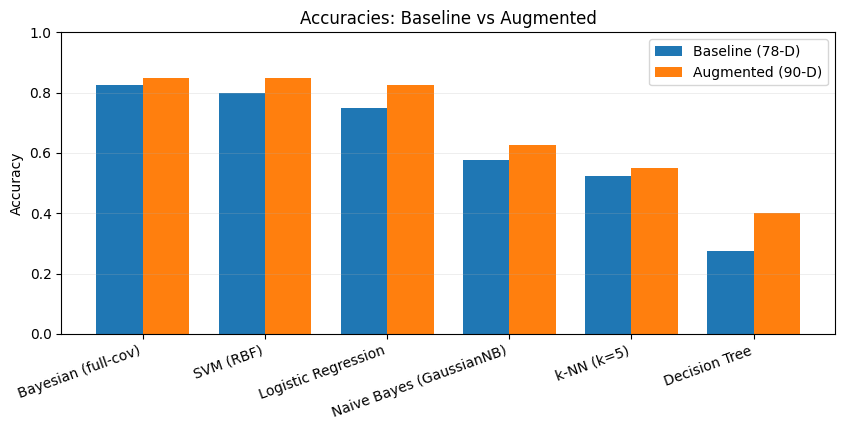

In [20]:
# ==============================================================
# Step 7 (bonus) — Extra features per utterance + comparison
#   Extra frame descriptors (per utterance: mean & std):
#     - ZCR, Spectral Centroid, Bandwidth, Rolloff(0.85),
#       RMS Energy, Spectral Flatness
#   Total extra dims = 6 × 2 = 12 → augmented X ∈ ℝ^{N×90}
#   + Summary table and comparison diagram (baseline vs augmented)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def aggregate_extra_features(wavs, sr, win_ms=25, hop_ms=10):
    """
    Compute extra frame-level descriptors with 25 ms / 10 ms analysis
    and aggregate (mean, std) per utterance → (N, 12).
    """
    hop_length = int(round((hop_ms / 1000.0) * sr))     # 10 ms @ 16 kHz → 160
    win_length = int(round((win_ms / 1000.0) * sr))     # 25 ms @ 16 kHz → 400
    n_fft = 1 << (win_length - 1).bit_length()          # power-of-two ≥ win_length → 512

    extra_vecs = []
    for w in wavs:
        # Each returns shape (~1, T). Squeeze to (T,) for aggregation.
        zcr      = librosa.feature.zero_crossing_rate(w, frame_length=win_length, hop_length=hop_length).squeeze()
        centroid = librosa.feature.spectral_centroid(y=w, sr=sr, n_fft=n_fft, hop_length=hop_length).squeeze()
        bandwidth= librosa.feature.spectral_bandwidth(y=w, sr=sr, n_fft=n_fft, hop_length=hop_length).squeeze()
        rolloff  = librosa.feature.spectral_rolloff(y=w, sr=sr, roll_percent=0.85, n_fft=n_fft, hop_length=hop_length).squeeze()
        rms      = librosa.feature.rms(y=w, frame_length=win_length, hop_length=hop_length).squeeze()
        flat     = librosa.feature.spectral_flatness(y=w, n_fft=n_fft, hop_length=hop_length).squeeze()

        feats = []
        for arr in (zcr, centroid, bandwidth, rolloff, rms, flat):
            a = np.asarray(arr, dtype=np.float64)
            feats.extend([a.mean(), a.std(ddof=0)])     # (mean, std) per descriptor
        extra_vecs.append(np.asarray(feats, dtype=np.float32))  # length 12
    return np.vstack(extra_vecs)  # (N, 12)

# ------------------ Build augmented representation (N x 90) ------------------
X_extra = aggregate_extra_features(wavs, Fs)
X_aug = np.hstack([X_stats, X_extra])

# Reuse the exact same split as the main cell (indices captured there)
idx_train = step7_idx_train
idx_test  = step7_idx_test

X_train_aug, X_test_aug = X_aug[idx_train], X_aug[idx_test]
y_train, y_test = y_labels[idx_train], y_labels[idx_test]

# Standardize augmented features for models that benefit from scaling
scaler_aug = StandardScaler()
X_train_aug_std = scaler_aug.fit_transform(X_train_aug)
X_test_aug_std  = scaler_aug.transform(X_test_aug)

# ------------------ Train the same suite of models on augmented features ------------------
results_bonus: Dict[str, float] = {}

# Full-cov Bayesian (uses standardized features)
bayes_aug = FullCovGaussianBayes(reg=1e-2).fit(X_train_aug_std, y_train)
results_bonus["Bayesian (full-cov)"] = accuracy_score(y_test, bayes_aug.predict(X_test_aug_std))

# GaussianNB (standardized)
gnb_aug = GaussianNB().fit(X_train_aug_std, y_train)
results_bonus["Naive Bayes (GaussianNB)"] = accuracy_score(y_test, gnb_aug.predict(X_test_aug_std))

# SVM RBF (standardized)
svm_aug = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=step7_random_state).fit(X_train_aug_std, y_train)
results_bonus["SVM (RBF)"] = accuracy_score(y_test, svm_aug.predict(X_test_aug_std))

# k-NN (standardized)
knn_aug = KNeighborsClassifier(n_neighbors=5).fit(X_train_aug_std, y_train)
results_bonus["k-NN (k=5)"] = accuracy_score(y_test, knn_aug.predict(X_test_aug_std))

# Logistic Regression (standardized)
lr_aug = LogisticRegression(max_iter=2000, random_state=step7_random_state).fit(X_train_aug_std, y_train)
results_bonus["Logistic Regression"] = accuracy_score(y_test, lr_aug.predict(X_test_aug_std))

# (ADDED) Decision Tree — like the main step, use RAW features (no scaling)
dt_aug = DecisionTreeClassifier(random_state=step7_random_state).fit(X_train_aug, y_train)
results_bonus["Decision Tree"] = accuracy_score(y_test, dt_aug.predict(X_test_aug))

# ------------------ Aligned comparison table: baseline vs augmented (+Δ) ------------------
print("\nStep 7 — Test accuracies: baseline 78-D vs augmented 90-D")
rows_keys = sorted(step7_results_main.keys(), key=lambda k: -step7_results_main[k])
name_w = max(len(k) for k in rows_keys)
print(f"{'Model':<{name_w}}  {'Base':>7}  {'Aug':>7}  {'Δ':>7}")
print(f"{'-'*name_w}  {'-'*7}  {'-'*7}  {'-'*7}")

for name in rows_keys:
    acc_base = step7_results_main[name]
    acc_aug  = results_bonus.get(name, np.nan)
    delta    = acc_aug - acc_base if np.isfinite(acc_aug) else np.nan
    print(f"{name:<{name_w}}  {acc_base:>7.4f}  {acc_aug:>7.4f}  {delta:>+7.4f}")

print() # blank line

# ------------------ Diagram: paired bar chart (baseline vs augmented) ------------------
plt.figure(figsize=(8.6, 4.4))
x = np.arange(len(rows_keys))
base_vals = [step7_results_main[k] for k in rows_keys]
# (ROBUST) use .get with np.nan to avoid KeyError if a model is missing from results_bonus
aug_vals  = [results_bonus.get(k, np.nan) for k in rows_keys]
w = 0.38
plt.bar(x - w/2, base_vals, width=w, label="Baseline (78-D)")
plt.bar(x + w/2, aug_vals,  width=w, label="Augmented (90-D)")
plt.xticks(x, rows_keys, rotation=20, ha='right')
plt.ylabel("Accuracy")
plt.title("Accuracies: Baseline vs Augmented")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()


### **Step 8 — RNN/GRU/LSTM on sin→cos: dataset, models, training, and results**

**What we implement (per PDF).**  
We generate short, uniformly sampled sequences from a sine wave and learn to predict the corresponding cosine at the **same timestamps**. We train **three recurrent models**—vanilla **RNN(tanh)**, **GRU**, and **LSTM**—and compare them using **MSE** on validation/test sets and qualitative plots.

---

#### **Dataset and design choices**

- **Signal model.**

  For each sequence $n$ with random start phase $\phi_n \sim \mathcal{U}[0,2\pi)$:

  $
  x_{n,k}=\sin\!\big(\phi_n+\omega k\Delta t\big), \qquad
  y_{n,k}=\cos\!\big(\phi_n+\omega k\Delta t\big),
  $

  where
  
  $\omega=2\pi f$, $f=40\text{ Hz}$, length $L=10$, and **fixed** $\Delta t=1\,\text{ms}$, $1\text{ kHz}$ sampling.
- **Why these numbers.**

  $\mathbf{f=40\text{ Hz}\Rightarrow T=25\,\text{ms}}$. Our 10-point window spans $10\,\text{ms}\approx0.4T$: short but sufficient to infer phase. Sampling is far above Nyquist (80 Hz), so no aliasing.

---

* **Split.** $N=4096$ total sequences $\rightarrow$ **64% train / 16% val / 20% test** (deterministic slicing).
* **Why a recurrent model?** Since $\cos(\theta)=\sin(\theta+\pi/2)$ and $\Delta t\neq T/4=6.25\,\text{ms}$, this is **not** a trivial time shift across indices. The model must use the **temporal context** in $x_{n,0:L}$ to infer the phase and produce the correct $y_{n,0:L}$.

---

#### **Model architecture (identical head for all three)**

- **Backbone:** one recurrent block with `batch_first=True` and hidden size **32**:
  - **RNN(tanh)** (no gates), **GRU**, **LSTM** (with gates).
- **Head:** a **linear layer per time step** mapping hidden state to $y\in\mathbb{R}^{L\times1}$.
- **Rationale:** \(H=32\) is ample for a 1D smooth mapping on length-10 sequences while limiting overfitting; one layer is sufficient.

---

#### **Training & evaluation protocol**

- **Loss / optimizer.** Mean Squared Error (**MSE**) with **Adam**, learning rate $10^{-2}$.
  $
  \mathrm{MSE}=\frac{1}{N L}\sum_{n,k}\big(\hat{y}_{n,k}-y_{n,k}\big)^2 .
  $
- **Early stopping.** Track **validation MSE** each epoch; keep the **best** weights; **patience = 20**.
- **Mini-batching.** Batch size **128** via PyTorch `DataLoader`.
- **Fair comparison.** We reset the **random seed** before training each model so initialization and shuffling are aligned.
- **Diagnostics.** We plot **training/validation curves**, a **test-MSE bar chart**, and **overlays** of prediction vs target for the **first 3 test sequences**. Inference uses `model.eval()` and `no_grad()`.

---

#### **Results (your run)**

- **Validation/Test MSE (lower is better):**
  - **GRU:** val **0.04863**, test **0.04923**
  - **LSTM:** val **0.04858**, test **0.04924**
  - **RNN:** val **0.04874**, test **0.04931**
- **Training/validation curves:** fast drop in the first ~15 epochs, then a smooth plateau; **train and val curves overlap**, indicating no overfitting (noise-free task).
- **Qualitative plots:** the dashed predictions sit **on top of** the cosine targets across all three models; no visible phase bias by the end.

**Interpretation.**
- All three models achieve **near-identical** performance (differences on the order of $10^{-4}$ MSE), which is expected for a **noise-free, low-complexity** mapping with very short sequences.  
- **Gated units** (GRU/LSTM) are slightly more stable and reach the plateau as quickly as RNN; the final gap is **not statistically meaningful** here (different seeds could flip the order).
- If we **increase difficulty**—add measurement noise, jitter the frequency, lengthen sequences, or change the target to a **one-step-ahead** forecast—**GRU/LSTM** typically show clearer advantages (better gradient flow, longer effective memory).

---

**Bottom line.** On this controlled task, all models learn the phase relationship accurately; **GRU/LSTM** offer minor robustness/convergence benefits but the task is easy enough that **vanilla RNN** is competitive.


RNN training:   0%|          | 0/200 [00:00<?, ?it/s]

GRU training:   0%|          | 0/200 [00:00<?, ?it/s]

LSTM training:   0%|          | 0/200 [00:00<?, ?it/s]

Step 8 — Validation/Test MSE (lower is better)
Model     Val MSE    Test MSE
----  ----------  ----------
GRU     0.048628    0.049233
LSTM    0.048576    0.049238
RNN     0.048744    0.049311



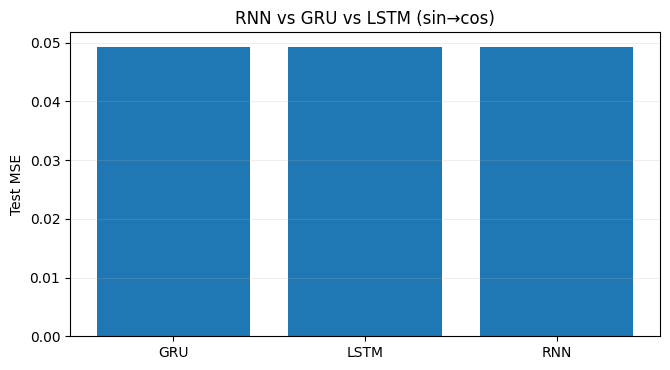

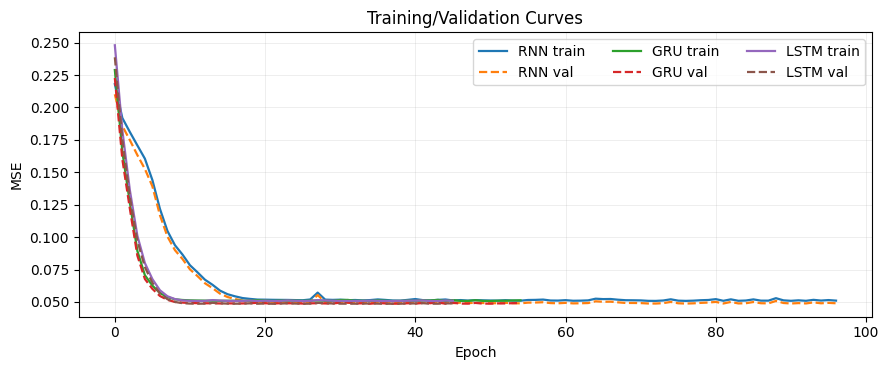

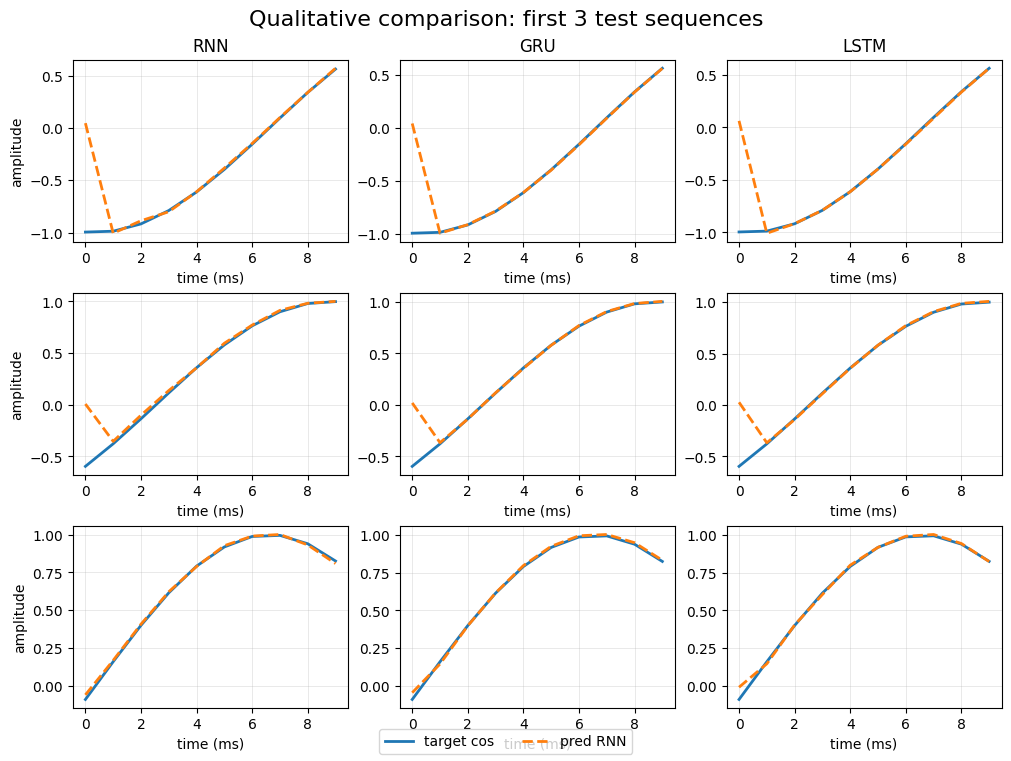

In [23]:
# ==============================================================
# Step 8 — Train RNN vs GRU vs LSTM on sin→cos sequence regression and compare
#   - Data: length-10 sequences sampled at 1 kHz from a 40 Hz sine;
#           target is the phase-shifted cosine at the same timestamps.
#   - Models: vanilla RNN(tanh), GRU, LSTM → seq2seq with linear head
#   - Training: Adam + MSE, validation early stopping (patience=20)
#   - Outputs: Val/Test MSE table, bar chart, qualitative overlays,
#              (added) loss curves per model
# ==============================================================

import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import trange

# -----------------------------
# Reproducibility & device
# -----------------------------
def set_seed(seed: int = 0):
    """Set all relevant RNG seeds for fair model comparison."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Synthetic dataset: sin→cos
# -----------------------------
def make_sin_cos_dataset(
    N_total: int = 4096,
    L: int = 10,
    f: float = 40.0,
    dt: float = 1.0 / 1000.0,  # 1 kHz sampling → small, fixed step
):
    """
    Build sin/cos pairs with random start phase:
      x[n, k] = sin(phi_n + ω k Δt)
      y[n, k] = cos(phi_n + ω k Δt)
    Returns tensors for train/val/test plus the time axis in seconds.
    """
    omega = 2.0 * math.pi * f
    k = np.arange(L, dtype=np.float32)
    t = k * dt
    phase_steps = omega * t

    # Random start phase per sequence
    phi = np.random.rand(N_total) * 2.0 * math.pi

    x_seq = np.sin(phi[:, None] + phase_steps[None, :]).astype(np.float32)[..., None]  # (N, L, 1)
    y_seq = np.cos(phi[:, None] + phase_steps[None, :]).astype(np.float32)[..., None]  # (N, L, 1)

    # Deterministic split: 64% train, 16% val, 20% test
    N_train = int(0.64 * N_total)
    N_val   = int(0.16 * N_total)
    N_test  = N_total - N_train - N_val

    Xtr, Ytr = x_seq[:N_train],               y_seq[:N_train]
    Xva, Yva = x_seq[N_train:N_train+N_val],  y_seq[N_train:N_train+N_val]
    Xte, Yte = x_seq[-N_test:],               y_seq[-N_test:]

    # Torch tensors (float32)
    Xtr, Ytr = torch.from_numpy(Xtr), torch.from_numpy(Ytr)
    Xva, Yva = torch.from_numpy(Xva), torch.from_numpy(Yva)
    Xte, Yte = torch.from_numpy(Xte), torch.from_numpy(Yte)

    return (Xtr, Ytr, Xva, Yva, Xte, Yte, t)

# Build data once for all models
Xtr, Ytr, Xva, Yva, Xte, Yte, t_axis = make_sin_cos_dataset()

# DataLoaders (mini-batch SGD)
batch_size = 128
train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, Yva), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, Yte), batch_size=batch_size, shuffle=False)

# -----------------------------
# Model: RNN / GRU / LSTM
# -----------------------------
class Seq2SeqRNN(nn.Module):
    """
    Sequence-to-sequence regressor: input (B, L, 1) → output (B, L, 1).
    A recurrent block (RNN/GRU/LSTM) followed by a linear head per timestep.
    """
    def __init__(self, cell_type: str = "LSTM", input_size: int = 1,
                 hidden_size: int = 32, num_layers: int = 1):
        super().__init__()
        c = cell_type.upper()
        if c == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True, nonlinearity="tanh")
        elif c == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True)
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, L, 1) → rnn output h: (B, L, H) → linear head per step → (B, L, 1)
        """
        h, _ = self.rnn(x)
        y = self.head(h)
        return y

# -----------------------------
# Evaluation helper (MSE)
# -----------------------------
def evaluate_mse(model: nn.Module, loader: DataLoader, device) -> float:
    """Compute mean MSE over all batches in loader."""
    model.eval()
    crit = nn.MSELoss(reduction="mean")
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            mse_batch = crit(pred, yb).item()
            mse_sum += mse_batch * xb.size(0)
            n += xb.size(0)
    return mse_sum / max(n, 1)

# -----------------------------
# Training with validation & early stopping
# -----------------------------
def train_and_eval(cell_type: str, hidden_size: int = 32, num_layers: int = 1,
                   lr: float = 1e-2, epochs: int = 200, patience: int = 20):
    """
    Train the given recurrent model with early stopping on validation MSE.
    Returns a dict containing:
      - 'val_mse': best validation MSE
      - 'test_mse': test MSE after restoring best weights
      - 'preds': predictions (first 3 test sequences)
      - 'train_hist', 'val_hist': MSE histories per epoch
    """
    set_seed(0)  # identical init for fair comparison
    model = Seq2SeqRNN(cell_type=cell_type, hidden_size=hidden_size,
                       num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad_epochs = 0

    train_mse_hist, val_mse_hist = [], []

    for ep in trange(1, epochs + 1, desc=f"{cell_type} training", leave=False):
        # ---- train for one epoch ----
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            optimizer.step()

        # ---- evaluate at epoch end ----
        tr_mse = evaluate_mse(model, train_loader, device)
        va_mse = evaluate_mse(model, val_loader, device)
        train_mse_hist.append(tr_mse)
        val_mse_hist.append(va_mse)

        # ---- early stopping bookkeeping ----
        if va_mse < best_val - 1e-8:
            best_val = va_mse
            # store a CPU copy of parameters (safe w.r.t. in-place updates)
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    # ---- restore best weights & test ----
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    test_mse = evaluate_mse(model, test_loader, device)

    # ---- qualitative predictions on a few test samples ----
    model.eval()  # ensure eval-mode for inference (important if using dropout/bn)
    with torch.no_grad():
        yhat = model(Xte[:3].to(device)).cpu().numpy()  # (3, L, 1)

    return {
        "val_mse": best_val,
        "test_mse": test_mse,
        "preds": yhat,
        "train_hist": train_mse_hist,
        "val_hist": val_mse_hist,
    }

# -----------------------------
# Train all three models
# -----------------------------
results = {}
for ct in ["RNN", "GRU", "LSTM"]:
    results[ct] = train_and_eval(
        ct, hidden_size=32, num_layers=1, lr=1e-2, epochs=200, patience=20
    )

# -----------------------------
# Summary table
# -----------------------------
print("Step 8 — Validation/Test MSE (lower is better)")
rows = [(k, v["val_mse"], v["test_mse"]) for k, v in results.items()]
rows.sort(key=lambda x: x[2])  # sort by test MSE (ascending)
name_w = max(len(k) for k, _, _ in rows)
print(f"{'Model':<{name_w}}  {'Val MSE':>10}  {'Test MSE':>10}")
print(f"{'-'*name_w}  {'-'*10}  {'-'*10}")
for k, vm, tm in rows:
    print(f"{k:<{name_w}}  {vm:>10.6f}  {tm:>10.6f}")

print() # blank line

# -----------------------------
# Diagram: bar chart (Test MSE)
# -----------------------------
plt.figure(figsize=(6.8, 3.8))
labels = [k for k, _, _ in rows]
test_mses = [tm for _, _, tm in rows]
plt.bar(range(len(labels)), test_mses)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Test MSE")
plt.title("RNN vs GRU vs LSTM (sin→cos)")
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # blank line

# -----------------------------
# Loss curves per model (train vs val MSE)
# -----------------------------
plt.figure(figsize=(9.0, 3.8))
for ct in ["RNN", "GRU", "LSTM"]:
    plt.plot(results[ct]["train_hist"], label=f"{ct} train", linewidth=1.6)
    plt.plot(results[ct]["val_hist"],   label=f"{ct} val",   linewidth=1.6, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training/Validation Curves")
plt.legend(ncol=3)
plt.grid(alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # blank line

# -----------------------------
# Qualitative comparison: first 3 test sequences
# -----------------------------
t_ms = t_axis * 1000.0

fig, axs = plt.subplots(3, 3, figsize=(10, 7.5), constrained_layout=True)
fig.suptitle("Qualitative comparison: first 3 test sequences", fontsize=16)
for i in range(3):  # rows: example index
    cos_tgt = Yte[i, :, 0].numpy()
    for j, ct in enumerate(["RNN", "GRU", "LSTM"]):  # cols: model type
        ax = axs[i, j]
        ax.plot(t_ms, cos_tgt, label="target cos", linewidth=2)
        ax.plot(t_ms, results[ct]["preds"][i, :, 0], "--", label=f"pred {ct}", linewidth=2)
        if i == 0:
            ax.set_title(ct)
        if j == 0:
            ax.set_ylabel("amplitude")
        ax.set_xlabel("time (ms)")
        ax.grid(alpha=0.4, linewidth=0.5)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3)
plt.show()


---

### **AI Usage Declaration**

The **core content and solution** submitted for this project is the product of our team's **independent intellectual effort**.

**AI-based tools were used strictly for supplementary support** by team members, including:

- **Formatting and organizing** markdown cells for improved clarity,
- **Troubleshooting** specific coding issues,
- **Writing code snippets** based on our team's logic and instructions, and
- **Translating content** from Greek to English for documentation and clarity.

At no point was AI used to generate or influence the **core logic**, **design choices**, or **solutions** required for this project.